# Task #7 by Jogesh Mishra 

### The task demands to form a model using the Numerical as well as Textual analysis of Stock Market Prices and News Headlines respectively. 

## Importing the required libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,Activation
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Using TensorFlow backend.


#### Incase you don't have 'vader_lexicon' package of nltk downloaded, we can run the dollowing snippet : 

###### This is important for SentimentIntensityAnalyzer from nltk.sentiment.vader

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# Load the Datasets 

<b>'BSESN.csv'</b> has downloaded from https://bit.ly/3kXTdox and 
<b>'india-news-headlines.csv'</b> has been downloaded from https://bit.ly/3kXTdox 


In [3]:
stock_price = pd.read_csv('BSESN.csv')
headlines = pd.read_csv('india-news-headlines.csv')

## Preliminary actions on stock_price dataset :

In [4]:
stock_price.shape

(5981, 7)

##### Checking for null values and dropping the respective rows(if any) :

In [5]:
stock_price.isna().sum()

Date            0
Open         1034
High         1034
Low          1034
Close        1034
Adj Close    1034
Volume       1034
dtype: int64

In [6]:
stock_price.dropna(axis=0,inplace=True)

#### Converting the Date column of stock_prices to DateTime object to arrange the given prices according to the date in increasing order :

In [7]:
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price.sort_values('Date',ascending=True)
stock_price.set_index('Date',inplace=True)
stock_price.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1331.00,1336.75,1289.25,1300.0,1300.0,92668.0
2001-01-03,1301.00,1367.25,1288.75,1359.0,1359.0,130684.0
2001-01-04,1360.00,1365.50,1341.50,1349.0,1349.0,110846.0
2001-01-05,1345.75,1380.00,1303.00,1304.0,1304.0,117776.0
2001-01-08,1308.25,1312.50,1287.50,1309.5,1309.5,120010.0


## Preliminary actions on headlines dataset :

#### Checking if any value is duplicated and dropping the rows with duplicate values (if any) :

In [8]:
headlines.duplicated().sum()

21585

In [9]:
headlines = headlines.drop_duplicates()
headlines.head(5)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


#### Checking for null values and dropping the respective rows (if any) :

In [10]:
headlines.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

#### Selecting only the 'publish_date' and 'headline_text column' from headlines dataset :

In [11]:
headlines = headlines.filter(['publish_date','headline_text'])

#### As the date in publish_date column is not in right format, so we first bring it to the right format by string manipulation and later convert it to DateTime object :

In [12]:
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x : x[0:4]+'-'+x[4:6]+'-'+x[6:])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()

#### Grouping the headlines accordding to the publish_date so that all the headlines for a particular date can be kept in a single row, thus reducing the dimensionality of the dataset :

In [13]:
headlines = headlines.groupby('publish_date')['headline_text'].apply(lambda x : ''.join(x)).reset_index()

#### Changing the index of headlines dataset to 'publish_date' column and sorting the values according to increasing value of index : 

In [14]:
headlines.set_index('publish_date',inplace=True)
headlines.sort_index()

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,Powerless north India gropes in the darkThink ...
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


## Concatenating both the datasets to form the required dataframe 'df' :
### Dropping the rows with null values taht may occur due to dissimilar index values .

In [15]:
df = pd.concat([stock_price,headlines],axis=1)
df.dropna(axis=0,inplace=True)
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,headline_text
2001-01-02,1331.00,1336.75,1289.25,1300.00,1300.00,92668.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,1301.00,1367.25,1288.75,1359.00,1359.00,130684.0,Powerless north India gropes in the darkThink ...
2001-01-04,1360.00,1365.50,1341.50,1349.00,1349.00,110846.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,1345.75,1380.00,1303.00,1304.00,1304.00,117776.0,Light combat craft takes India into club class...
2001-01-08,1308.25,1312.50,1287.50,1309.50,1309.50,120010.0,Sangh Parivar; Babri panel up the anteFrontrun...
2001-01-09,1312.00,1325.50,1303.75,1308.75,1308.75,115968.0,Financier Bharat Shah held for alleged links w...
2001-01-10,1309.50,1328.75,1297.25,1327.00,1327.00,131074.0,Fend for yourselves; Pande tells doctorsBureau...
2001-01-11,1325.75,1343.50,1319.50,1335.00,1335.00,96098.0,shreyas gopal scores ton as karnataka stay on ...
2001-01-23,1356.75,1372.75,1348.50,1366.00,1366.00,105167.0,Sonia takes on the Hindutva brigadeCongress ho...
2001-01-24,1366.25,1379.00,1365.25,1370.25,1370.25,104969.0,Govt extends J&K ceasefire by a monthPeace hin...


#### Pre-requisite : We need 'vader_lexicon' package for SentimentIntensityAnalyzer

### Detecting the compound sentiment of the headline_texts and saving the value in 'compound' column of 'df' :

In [16]:

sid = SentimentIntensityAnalyzer()

df['compound'] = df['headline_text'].apply(lambda x : sid.polarity_scores(x)['compound'])
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,headline_text,compound
2001-01-02,1331.00,1336.75,1289.25,1300.0,1300.0,92668.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621
2001-01-03,1301.00,1367.25,1288.75,1359.0,1359.0,130684.0,Powerless north India gropes in the darkThink ...,0.6322
2001-01-04,1360.00,1365.50,1341.50,1349.0,1349.0,110846.0,The string that pulled Stephen Hawking to Indi...,0.6648
2001-01-05,1345.75,1380.00,1303.00,1304.0,1304.0,117776.0,Light combat craft takes India into club class...,0.9253
2001-01-08,1308.25,1312.50,1287.50,1309.5,1309.5,120010.0,Sangh Parivar; Babri panel up the anteFrontrun...,-0.9638


#### Checking for null values if any :

In [17]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
headline_text    0
compound         0
dtype: int64

### EDA of the dataset :

In [18]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,compound
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4.920000e+03,4920.000000
mean,1630.062144,1641.527494,1618.092581,1630.794219,1630.794219,1.375471e+06,-0.869538
std,645.966664,649.090556,643.069552,646.652205,646.652205,8.473146e+05,0.455220
min,674.750000,694.750000,665.750000,676.000000,676.000000,0.000000e+00,-1.000000
25%,1144.250000,1154.937500,1136.000000,1144.937500,1144.937500,7.308308e+05,-0.999800
50%,1359.125000,1369.625000,1349.875000,1359.375000,1359.375000,1.285948e+06,-0.999100
75%,2068.312500,2079.000000,2052.500000,2069.000000,2069.000000,1.849832e+06,-0.994200
max,3391.750000,3397.500000,3382.000000,3388.250000,3388.250000,6.316426e+06,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4920 entries, 2001-01-02 to 2020-06-29
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           4920 non-null   float64
 1   High           4920 non-null   float64
 2   Low            4920 non-null   float64
 3   Close          4920 non-null   float64
 4   Adj Close      4920 non-null   float64
 5   Volume         4920 non-null   float64
 6   headline_text  4920 non-null   object 
 7   compound       4920 non-null   float64
dtypes: float64(7), object(1)
memory usage: 345.9+ KB


#### Plotting the close price for every date of the dataframe df :

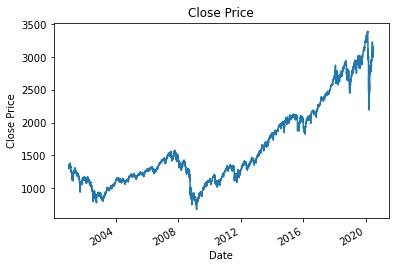

In [20]:
df['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

#### Shifting the index by 7 rows with the mean value to see the change in plot for the close price in this condition :

The NaN values are just for visualization purpose to see the rigidness of stock_price on a week gap.

In [21]:
df.rolling(7).mean().head(20)

,Open,High,Low,Close,Adj Close,Volume,compound
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,1323.928571,1345.178571,1301.571429,1322.464286,1322.464286,117003.714286,-0.175914
2001-01-11,1323.178571,1346.142857,1305.892857,1327.464286,1327.464286,117493.714286,-0.038471
2001-01-23,1331.142857,1346.928571,1314.428571,1328.464286,1328.464286,113848.428571,0.004000
2001-01-24,1332.035714,1348.857143,1317.821429,1331.500000,1331.500000,113008.857143,-0.220100


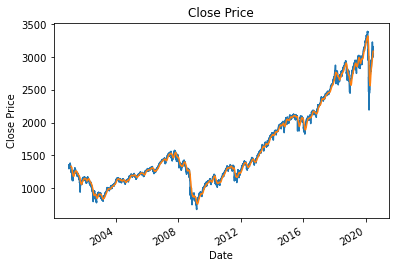

In [22]:
df['Close'].plot()
df.rolling(window=30).mean()['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Creating the required part for Train set and Test set :

#### We are going to make a model to predict stock price for the next day after an observation.

In [23]:
use_data_size = len(df) - 1
train_data_size = int(0.8 * use_data_size)
total_data_size = len(df)
start_point = total_data_size - use_data_size
print("Length of Training Set is ",train_data_size)
print('Length of Testing Set is ', total_data_size - train_data_size)

Length of Training Set is  3935
Length of Testing Set is  985


#### Separating the columns for to make the required dataframe later :

In [24]:
close_price = df.iloc[start_point:total_data_size,3]
compound = df.iloc[start_point:total_data_size,7]
open_price = df.iloc[start_point:total_data_size,0]
high = df.iloc[start_point:total_data_size,1]
low = df.iloc[start_point:total_data_size,2]
volume = df.iloc[start_point:total_data_size,5]

#### As we are going to predict the value for each succeeding day, so we need to shift the close_price as well as compound Series from dataframes to the next day :

In [25]:
close_price_shifted = close_price.shift(-1)
compound_shifted = compound.shift(-1)

#### Concatenating all the Series to form the required dataframe for our model  :

In [26]:
stock_price_data = pd.DataFrame({
    'close':close_price,
    'close_price_shifted':close_price_shifted,
    'compound':compound,
    'compound_shifted':compound_shifted,
    'open':open_price,
    'high':high,
    'low':low,
    'volume':volume
                                })

In [27]:
stock_price_data.head()

,close,close_price_shifted,compound,compound_shifted,open,high,low,volume
2001-01-03,1359.00,1349.00,0.6322,0.6648,1301.00,1367.25,1288.75,130684.0
2001-01-04,1349.00,1304.00,0.6648,0.9253,1360.00,1365.50,1341.50,110846.0
2001-01-05,1304.00,1309.50,0.9253,-0.9638,1345.75,1380.00,1303.00,117776.0
2001-01-08,1309.50,1308.75,-0.9638,-0.9559,1308.25,1312.50,1287.50,120010.0
2001-01-09,1308.75,1327.00,-0.9559,-0.5719,1312.00,1325.50,1303.75,115968.0


#### Checking for null values in stock_price_data dataframe and dropping the respective rows (if any) :

In [28]:
stock_price_data.isnull().sum()

close                  0
close_price_shifted    1
compound               0
compound_shifted       1
open                   0
high                   0
low                    0
volume                 0
dtype: int64

In [29]:
stock_price_data.dropna(axis=0,inplace=True)

#### Creating the output variable (here, teh close_price_shifted or close_price after one day) as y:

In [30]:
y = stock_price_data['close_price_shifted']
y.shape

(4918,)

#### Creating the predictor variables by dropping the 'close_price_shifted' column from stock_price_data : 

In [31]:
x = stock_price_data.drop(['close_price_shifted'],axis=1)
x.head()

,close,compound,compound_shifted,open,high,low,volume
2001-01-03,1359.00,0.6322,0.6648,1301.00,1367.25,1288.75,130684.0
2001-01-04,1349.00,0.6648,0.9253,1360.00,1365.50,1341.50,110846.0
2001-01-05,1304.00,0.9253,-0.9638,1345.75,1380.00,1303.00,117776.0
2001-01-08,1309.50,-0.9638,-0.9559,1308.25,1312.50,1287.50,120010.0
2001-01-09,1308.75,-0.9559,-0.5719,1312.00,1325.50,1303.75,115968.0


#### Scaling the variables to keep the value between -1 to 1 using MinMaxScaler inorder to restrict huge changes in data :

In [32]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
y = scaler.fit_transform(np.array(y).reshape(-1,1))
x = scaler.fit_transform(x)

#### Creating the Training Set and Testing Set :

In [33]:
X_train = x[:train_data_size,]
X_test = x[train_data_size + 1: len(x),]
y_train = y[:train_data_size,]
y_test = y[train_data_size + 1 : len(y),]
print('Size of Training set X : ',X_train.shape)
print('Size of Test set X : ',X_test.shape)
print('Size of Training set Y : ',y_train.shape)
print('Size of Testing set Y : ',y_test.shape)

Size of Training set X :  (3935, 7)
Size of Test set X :  (982, 7)
Size of Training set Y :  (3935, 1)
Size of Testing set Y :  (982, 1)


#### Reshaping the X_train and X_test to 3D arrays for the model :


In [34]:
X_train = X_train.reshape(-1,7,1)
X_test = X_test.reshape(-1,7,1)

## Creating the model :

#### Here, as the question demands to learn from it's past values , so we will go for LSTM layers or RNN analogy to perform our task.

In [35]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, activation='tanh',input_shape= X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

## Fitting the model on Training Set as well as checking it's performance on Test set :

In [36]:
model.compile(optimizer='rmsprop',loss='mse')
history = model.fit(X_train,y_train, epochs=20, batch_size=10, validation_data=(X_test,y_test))

Train on 3935 samples, validate on 982 samples
Epoch 1/20
3935/3935 [==============================] - 12s 3ms/step - loss: 0.0298 - val_loss: 0.0132
Epoch 2/20
3935/3935 [==============================] - 11s 3ms/step - loss: 0.0084 - val_loss: 0.0155
Epoch 3/20
3935/3935 [==============================] - 10s 3ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 4/20
3935/3935 [==============================] - 10s 3ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 5/20
3935/3935 [==============================] - 10s 3ms/step - loss: 0.0024 - val_loss: 0.0142
Epoch 6/20
3935/3935 [==============================] - 10s 3ms/step - loss: 0.0021 - val_loss: 0.0166
Epoch 7/20
3935/3935 [==============================] - 10s 2ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 8/20
3935/3935 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0135
Epoch 9/20
3935/3935 [==============================] - 10s 2ms/step - loss: 0.0016 - val_loss: 0.0138
Epoch 10/20
3935/3935 [===

## Plot of Loss vs Epoch for the given Model :

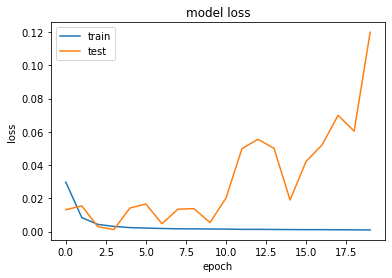

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model and respective Weights :

In [38]:
model_json = model.to_json()
with open('model.json','w') as file :
    file.write(model_json)
model.save_weights('model.h5')

### With this, we have come to the end of creating a hybrid model for Stock Market Prediction using Numerical and Textual Analysis. The model and weighst are saved as model.json and model.h5 respectiely.